In [ ]:
from google.colab import files

uploaded = files.upload()

Saving combined_cleaned_train.csv to combined_cleaned_train.csv


In [ ]:
import pandas as pd

combined_train = pd.read_csv("combined_cleaned_train.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'combined_cleaned_train.csv'

In [ ]:
uploaded = files.upload()

Saving combined_cleaned_test.csv to combined_cleaned_test.csv


In [ ]:
combined_test = pd.read_csv("combined_cleaned_test.csv")

In [ ]:
uploaded = files.upload()

Saving neurology_cleaned_train.csv to neurology_cleaned_train.csv


In [ ]:
uploaded = files.upload()

Saving neurology_cleaned_test.csv to neurology_cleaned_test.csv


In [ ]:
neurology_train = pd.read_csv("neurology_cleaned_train.csv")
neurology_test = pd.read_csv("neurology_cleaned_test.csv")

In [ ]:
neurology_train = neurology_train.drop(columns=['valuenum'])
neurology_test = neurology_test.drop(columns=['valuenum'])

In [ ]:
uploaded = files.upload()

Saving fb_cleaned_train.csv to fb_cleaned_train.csv


In [ ]:
uploaded = files.upload()

Saving fb_cleaned_test.csv to fb_cleaned_test.csv


In [ ]:
fb_train = pd.read_csv("fb_cleaned_train.csv")
fb_test = pd.read_csv("fb_cleaned_test.csv")

In [ ]:
fb_train = fb_train.drop(columns=['valuenum'])
fb_test = fb_test.drop(columns=['valuenum'])

In [ ]:
combined_train = pd.concat([combined_train, neurology_train], axis=0, ignore_index=True)
combined_test = pd.concat([combined_test, neurology_test], axis=0, ignore_index=True)

In [ ]:
combined_train['charttime'] = pd.to_datetime(combined_train['charttime'], errors='coerce')
combined_test['charttime'] = pd.to_datetime(combined_test['charttime'], errors='coerce')
fb_train['charttime'] = pd.to_datetime(fb_train['charttime'], errors='coerce')
fb_test['charttime'] = pd.to_datetime(fb_test['charttime'], errors='coerce')

In [ ]:
# Function to create 12h timesteps for lstm model

import pandas as pd
import numpy as np

def preprocess_for_lstm(df, time_col='charttime', value_col='valuenum_normalized', time_steps=12):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])

    # Calculate feature-wise median across all patients
    global_medians = df.groupby('label')[value_col].median()

    # Store ext_success per subject_id + stay_id
    if 'ext_success' in df.columns:
        ext_success_map = df.groupby(['subject_id', 'stay_id'])['ext_success'].first().to_dict()
    else:
        ext_success_map = {}

    # Compute start time per stay for binning
    df['start_time'] = df.groupby(['subject_id', 'stay_id'])[time_col].transform('min')

    # Bin into 12 intervals (2 hours each)
    df['bin'] = ((df[time_col] - df['start_time']) / pd.Timedelta(hours=2)).astype(int)
    df = df[df['bin'].between(0, time_steps - 1)]

    processed_data = []

    # For each patient
    for (subject_id, stay_id), group in df.groupby(['subject_id', 'stay_id']):
        # Pivot: rows are bins, columns are features (labels)
        pivot = group.pivot_table(index='bin', columns='label', values=value_col, aggfunc='mean')

        # Ensure 12 time steps
        pivot = pivot.reindex(range(time_steps))

        # Track which features exist for this patient
        existing_features = pivot.columns[pivot.notna().any()].tolist()
        all_features = global_medians.index.tolist()

        # Fill missing features entirely with median
        for feature in all_features:
            if feature not in pivot.columns:
                pivot[feature] = global_medians[feature]

        # Sort columns for consistency
        pivot = pivot[all_features]

        # Forward-fill then backward-fill
        pivot = pivot.ffill().bfill()

        # Fill first value if still missing
        for feature in pivot.columns:
            if pd.isna(pivot.iloc[0][feature]):
                pivot.iloc[0, pivot.columns.get_loc(feature)] = global_medians[feature]
                pivot[feature] = pivot[feature].ffill().bfill()

        # Add patient metadata
        pivot['subject_id'] = subject_id
        pivot['stay_id'] = stay_id
        pivot['bin'] = pivot.index

        # Add ext_success if available
        if (subject_id, stay_id) in ext_success_map:
            pivot['ext_success'] = ext_success_map[(subject_id, stay_id)]

        processed_data.append(pivot.reset_index(drop=True))

    # Concatenate all patient data
    final_df = pd.concat(processed_data, ignore_index=True)

    # Reorder columns: id columns first
    id_cols = ['subject_id', 'stay_id', 'bin']
    if 'ext_success' in final_df.columns:
        id_cols.append('ext_success')

    feature_cols = [col for col in final_df.columns if col not in id_cols]
    final_df = final_df[id_cols + feature_cols]

    return final_df

In [ ]:
combined_train_processed = preprocess_for_lstm(combined_train)
combined_test_processed = preprocess_for_lstm(combined_test)

In [ ]:
combined_train_processed.head()

label,subject_id,stay_id,bin,ext_success,Alanine Aminotransferase (ALT),Albumin,Alkaline Phosphatase,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,Arterial Blood Pressure systolic,...,Sputum Amount,Temperature Fahrenheit,Tidal Volume (observed),Tidal Volume (spontaneous),Urea Nitrogen,Ventilator Mode,White Blood Cells,pCO2,pH,pO2
0,10002428,38875437,0,1,0.086694,0.475,0.12115,0.272500,0.357500,0.431535,...,0.0,0.924242,0.415,0.317,0.458333,0.0,0.131195,0.225806,0.715789,0.265849
1,10002428,38875437,1,1,0.086694,0.475,0.12115,0.277500,0.367500,0.443983,...,0.0,0.924242,0.415,0.317,0.458333,0.0,0.131195,0.225806,0.715789,0.265849
2,10002428,38875437,2,1,0.086694,0.475,0.12115,0.280000,0.370000,0.443983,...,0.0,0.924242,0.415,0.317,0.458333,0.0,0.131195,0.225806,0.715789,0.265849
3,10002428,38875437,3,1,0.086694,0.475,0.12115,0.256667,0.331667,0.387275,...,0.0,0.934848,0.376,0.317,0.458333,0.0,0.131195,0.225806,0.715789,0.265849
4,10002428,38875437,4,1,0.086694,0.475,0.12115,0.265000,0.332500,0.360996,...,0.0,0.921212,0.376,0.317,0.458333,0.0,0.131195,0.225806,0.715789,0.265849


In [ ]:
combined_test_processed.head()

label,subject_id,stay_id,bin,ext_success,Alanine Aminotransferase (ALT),Albumin,Alkaline Phosphatase,Arterial Blood Pressure diastolic,Arterial Blood Pressure mean,Arterial Blood Pressure systolic,...,Sputum Amount,Temperature Fahrenheit,Tidal Volume (observed),Tidal Volume (spontaneous),Urea Nitrogen,Ventilator Mode,White Blood Cells,pCO2,pH,pO2
0,10004733,39635619,0,1,0.116935,0.475,0.195072,0.28,0.38,0.477178,...,1.0,0.921212,0.423,0.392,0.75,1.0,0.099125,0.209677,0.673684,0.173824
1,10004733,39635619,1,1,0.116935,0.475,0.195072,0.28,0.38,0.477178,...,1.0,0.917172,0.423,0.392,0.75,1.0,0.099125,0.209677,0.673684,0.173824
2,10004733,39635619,2,1,0.116935,0.475,0.195072,0.28,0.38,0.477178,...,1.0,0.917172,0.423,0.392,0.75,1.0,0.099125,0.209677,0.673684,0.173824
3,10004733,39635619,3,1,0.116935,0.475,0.195072,0.28,0.38,0.477178,...,1.0,0.914141,0.423,0.392,0.75,1.0,0.099125,0.209677,0.673684,0.173824
4,10004733,39635619,4,1,0.116935,0.475,0.195072,0.28,0.38,0.477178,...,1.0,0.914141,0.424,0.433,0.75,1.0,0.099125,0.209677,0.673684,0.173824


In [ ]:
# Convert dataframes to tensors

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

class ExtubationDataset(Dataset):
    def __init__(self, df, sequence_len=12, feature_cols=None):
        self.sequence_len = sequence_len
        self.df = df

        if feature_cols is None:
            self.feature_cols = [col for col in df.columns if col not in ["subject_id", "stay_id", "ext_success", "bin"]]
        else:
            self.feature_cols = feature_cols

        self.grouped = df.groupby(["subject_id", "stay_id"])
        self.X, self.y = self._create_sequences()

    def _create_sequences(self):
        X_list, y_list = [], []
        for _, group in self.grouped:
            group = group.sort_values("bin")  # ✅ ensures correct 2h-timestep order
            x = group[self.feature_cols].values.astype(np.float32)
            if x.shape[0] != self.sequence_len:
                continue  # skip if incomplete
            y = group["ext_success"].values[-1]  # one label per stay
            X_list.append(x)
            y_list.append(y)
        return np.stack(X_list), np.array(y_list).astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [ ]:
# Define model

import torch.nn as nn
import torch.optim as optim

class LSTMNetworks(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.3):
        super().__init__()

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Fully connected output head
        self.output = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size // 2, 1),
        )

        self.hidden_size = hidden_size

    def forward(self, X):
        B, T, C = X.shape  # Batch, Time, Channels
        res, _ = self.lstm(X)

        # Shape: (B, T, 2, hidden_size)
        res = res.view(B, T, 2, self.hidden_size)

        # Combine forward (last timestep) and backward (first timestep) outputs
        out = torch.cat([res[:, -1, 0, :], res[:, 0, 1, :]], dim=-1)

        # Apply dropout before output layer
        out = self.dropout(out)

        return self.output(out)

In [ ]:
# Adjusting decision threshold to improve specificity

def find_best_threshold(y_true, y_probs):
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_thresh, best_spec = 0.5, 0
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        if specificity > best_spec:
            best_spec = specificity
            best_thresh = thresh
    return best_thresh, best_spec

In [ ]:
# Training loop identifying extubation failure as the minority class using class weighting, which is compatible with LSTM

from sklearn.utils.class_weight import compute_class_weight

def train_model(model, train_loader, val_loader, device, y_train_tensor, num_epochs=50, patience=5, pos_weight_multiplier=1.0):
    # Compute class weights
    y_np = y_train_tensor.numpy().flatten()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0., 1.]), y=y_np)
    pos_weight_val = (class_weights[0] / class_weights[1]) * pos_weight_multiplier
    pos_weight = torch.tensor(pos_weight_val, dtype=torch.float32).to(device)

    # Set loss function and optimizer
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)  # Increased weight_decay

    train_losses, val_losses = [], []
    val_aucs = []
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0
        y_true, y_probs = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

                probs = torch.sigmoid(output).cpu().numpy().flatten()
                y_probs.extend(probs)
                y_true.extend(y_batch.cpu().numpy().flatten())
        val_losses.append(val_loss / len(val_loader))

        # Compute validation AUC
        auc = roc_auc_score(y_true, y_probs)
        val_aucs.append(auc)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, Val AUC = {auc:.4f}")

        # Early stopping logic
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, val_aucs

In [ ]:
# Defining evaluation metrics

from sklearn.metrics import (
    roc_auc_score, confusion_matrix, f1_score, accuracy_score,
    precision_score, recall_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            probs = torch.sigmoid(output).cpu().numpy().flatten()
            y_probs.extend(probs)
            y_true.extend(y_batch.numpy().flatten())

    y_pred = [1 if p >= 0.5 else 0 for p in y_probs]

    # Metrics
    auc = roc_auc_score(y_true, y_probs)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    print(f"AUC: {auc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall (Sensitivity): {rec:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("Confusion Matrix:\n", cm)

    threshold, best_spec = find_best_threshold(y_true, y_probs)
    print(f"Best threshold: {threshold}, Specificity: {best_spec:.4f}")

    # Confusion Matrix Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted: No', 'Predicted: Yes'],
                yticklabels=['Actual: No', 'Actual: Yes'])
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_losses(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
import torch

# Extract labels from the training dataframe
y_train = combined_train_processed['ext_success'].astype(float).values

# Convert to PyTorch tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

Epoch 1: Train Loss = 1.1103, Val Loss = 0.8303, Val AUC = 0.7616
Epoch 2: Train Loss = 0.7853, Val Loss = 0.7105, Val AUC = 0.7840
Epoch 3: Train Loss = 0.6986, Val Loss = 0.6653, Val AUC = 0.8094
Epoch 4: Train Loss = 0.6730, Val Loss = 0.6719, Val AUC = 0.8165
Epoch 5: Train Loss = 0.6557, Val Loss = 0.6742, Val AUC = 0.8219
Epoch 6: Train Loss = 0.6459, Val Loss = 0.6785, Val AUC = 0.8247
Epoch 7: Train Loss = 0.6368, Val Loss = 0.6458, Val AUC = 0.8273
Epoch 8: Train Loss = 0.6240, Val Loss = 0.6351, Val AUC = 0.8325
Epoch 9: Train Loss = 0.6186, Val Loss = 0.6528, Val AUC = 0.8316
Epoch 10: Train Loss = 0.6059, Val Loss = 0.6275, Val AUC = 0.8370
Epoch 11: Train Loss = 0.6162, Val Loss = 0.6329, Val AUC = 0.8364
Epoch 12: Train Loss = 0.6002, Val Loss = 0.6298, Val AUC = 0.8409
Epoch 13: Train Loss = 0.5911, Val Loss = 0.6363, Val AUC = 0.8339
Epoch 14: Train Loss = 0.5969, Val Loss = 0.6212, Val AUC = 0.8431
Epoch 15: Train Loss = 0.5978, Val Loss = 0.6208, Val AUC = 0.8396
Epoc

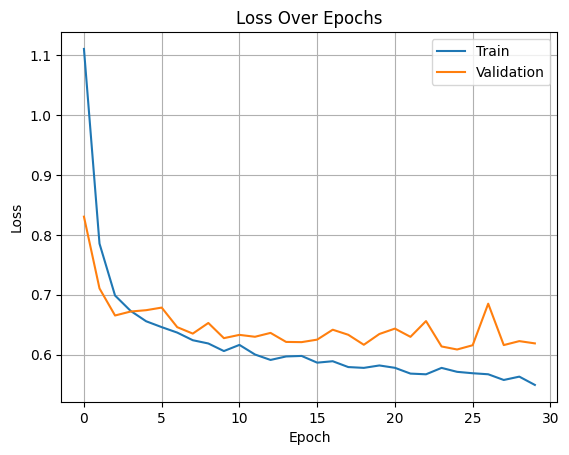

AUC: 0.8475
F1 Score: 0.9007
Accuracy: 0.8338
Precision: 0.8279
Recall (Sensitivity): 0.9875
Specificity: 0.3387
Confusion Matrix:
 [[ 84 164]
 [ 10 789]]
Best threshold: 0.8899999999999996, Specificity: 0.6290


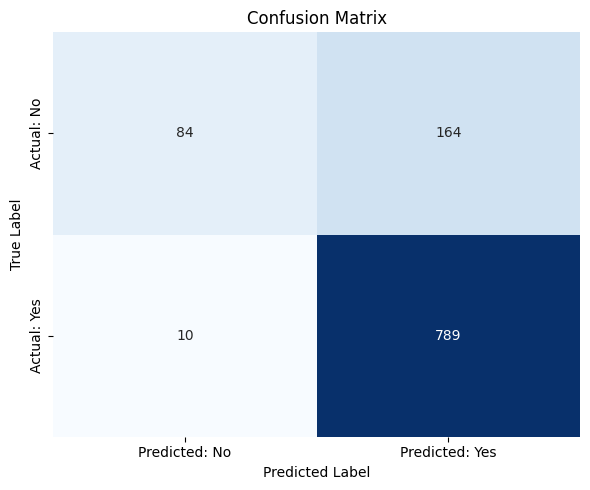

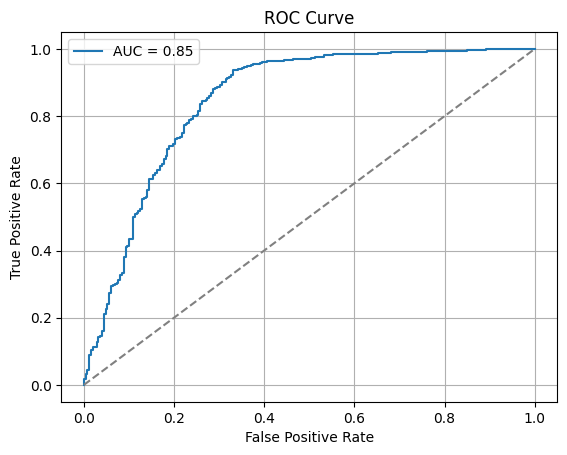

In [ ]:
# Run training

from torch.utils.data import DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

train_dataset = ExtubationDataset(combined_train_processed)
test_dataset = ExtubationDataset(combined_test_processed, feature_cols=train_dataset.feature_cols)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

model = LSTMNetworks(input_size=len(train_dataset.feature_cols), hidden_size=128).to(device)
model, train_losses, val_losses, val_aucs = train_model(
    model, train_loader, val_loader, device, y_train_tensor,
    num_epochs=50, patience=5, pos_weight_multiplier=1.5
)
plot_losses(train_losses, val_losses)
evaluate_model(model, test_loader, device)

In [ ]:
import shap

model.eval()

# Select sample inputs (e.g., 100 samples)
X_sample, _ = zip(*[test_dataset[i] for i in range(100)])
X_sample_tensor = torch.stack(X_sample).to(device).requires_grad_()  # shape: (100, 12, num_features)

# Define SHAP GradientExplainer
explainer = shap.GradientExplainer(model, X_sample_tensor)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample_tensor)

# Average over time (axis=1), keep features
shap_flat = np.mean(shap_values[0], axis=1)       # shape: (100, num_features)
X_flat = X_sample_tensor.detach().cpu().numpy().mean(axis=1)  # also (100, num_features)

# Plot summary
shap.summary_plot(shap_flat, X_flat, feature_names=train_dataset.feature_cols)

/tmp/ipython-input-33-1546681705.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_flat, X_flat, feature_names=train_dataset.feature_cols)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
# Merge static features with temporal data on subject_id and stay_id
combined_train = combined_train_processed.copy()
combined_test = combined_test_processed.copy()

# Make sure fb_train/test only have one row per subject_id + stay_id
static_cols = ['subject_id', 'stay_id', 'valuenum_normalized']  # add other static features if needed
fb_train_static = fb_train[static_cols].drop_duplicates()
fb_test_static = fb_test[static_cols].drop_duplicates()

# Merge (add static features to each row of time series)
combined_train = combined_train.merge(fb_train_static, on=['subject_id', 'stay_id'], how='left')
combined_test = combined_test.merge(fb_test_static, on=['subject_id', 'stay_id'], how='left')